### Task 1: Implement and Train a 2D U-Net

In [1]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import numpy as np
import cv2
from glob import glob
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
#from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.metrics import Recall, Precision
from UNet.utilities.model import build_model
import matplotlib.pyplot as plt
from UNet.utilities.metrics import dice_loss, dice_coef, iou
from UNet.utilities.pre_processing import load_data, tf_dataset, read_image, read_mask

Matplotlib is building the font cache; this may take a moment.


### Step 1: Data Preparation

In [2]:
path = '/blue/pinaki.sarder/akshitagupta/MicrovascularInf/Model_Development/Training/'

In [3]:
batch_size =32

In [4]:
(train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_data(path)
print('There are {} train images.'.format(len(train_x)))
print('There are {} test images.'.format(len(test_x)))
print('There are {} validation images.'.format(len(valid_x)))

train_dataset = tf_dataset(train_x, train_y,  batch=batch_size)
valid_dataset = tf_dataset(valid_x, valid_y,  batch=batch_size)

There are 816 train images.
There are 102 test images.
There are 102 validation images.


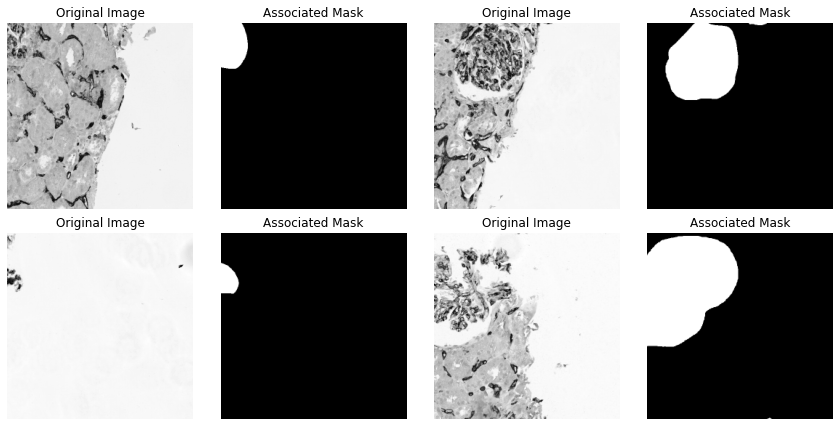

In [5]:
data = train_dataset.take(1)
count = 0
plt.figure(figsize = (12, 6))
for element in data:
    for i in range(0, 2):
        plt.subplot(2,4, count+1)
        plt.imshow(element[0][i,:,:,:], cmap = 'gray')
        plt.title('Original Image')
        plt.axis('off')
        plt.subplot(2,4, count+2)
        plt.imshow(element[1][i,:,:,:], cmap = 'gray')
        plt.title('Associated Mask')
        plt.axis('off')
        plt.subplot(2,4, count+3)
        plt.imshow(element[0][i+3,:,:,:], cmap = 'gray')
        plt.title('Original Image')
        plt.axis('off')
        plt.subplot(2,4, count+4)
        plt.imshow(element[1][i+3,:,:,:], cmap = 'gray')
        plt.title('Associated Mask')
        plt.axis('off')
        count+=4
    plt.tight_layout()
    # print(type(element[2]))

### Step 2: Model Architecture

In [6]:
H = 256
W = 256
lr = 0.005
model_path1 = './'
model_path =os.path.join(model_path1, "SavedModel/model.h5")
csv_path = os.path.join(model_path1, "data.csv")

In [7]:
model = build_model((H, W, 1))

### Step 3: Loss Function

In [8]:
metrics = [dice_coef, iou, Recall(), Precision()]
callbacks = [ModelCheckpoint(model_path, verbose=1, save_best_only=True),
             ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7, verbose=1),
             CSVLogger(csv_path)
            ]
model.compile(loss=dice_loss, optimizer=Adam(lr), metrics=metrics)

### Step 4: Training

In [9]:
num_epochs = 40
history = model.fit(train_dataset, epochs=num_epochs, batch_size= 8,validation_data=valid_dataset, callbacks=callbacks)

Epoch 1/40
26/26 [==============================] - 337s 8s/step - loss: 0.5220 - dice_coef: 0.4783 - iou: 0.3313 - recall: 0.7820 - precision: 0.3824 - val_loss: 0.7717 - val_dice_coef: 0.2274 - val_iou: 0.1285 - val_recall: 0.9999 - val_precision: 0.1305

Epoch 00001: val_loss improved from inf to 0.77169, saving model to ./SavedModel/model.h5
Epoch 2/40
26/26 [==============================] - 10s 363ms/step - loss: 0.1719 - dice_coef: 0.8281 - iou: 0.7073 - recall: 0.8969 - precision: 0.8001 - val_loss: 0.7734 - val_dice_coef: 0.2677 - val_iou: 0.1582 - val_recall: 0.9999 - val_precision: 0.1304

Epoch 00002: val_loss did not improve from 0.77169
Epoch 3/40
26/26 [==============================] - 10s 360ms/step - loss: 0.1434 - dice_coef: 0.8565 - iou: 0.7496 - recall: 0.9009 - precision: 0.8240 - val_loss: 0.7444 - val_dice_coef: 0.2475 - val_iou: 0.1414 - val_recall: 0.9915 - val_precision: 0.1485

Epoch 00003: val_loss improved from 0.77169 to 0.74439, saving model to ./SavedMo

### Step 5: Evaluation

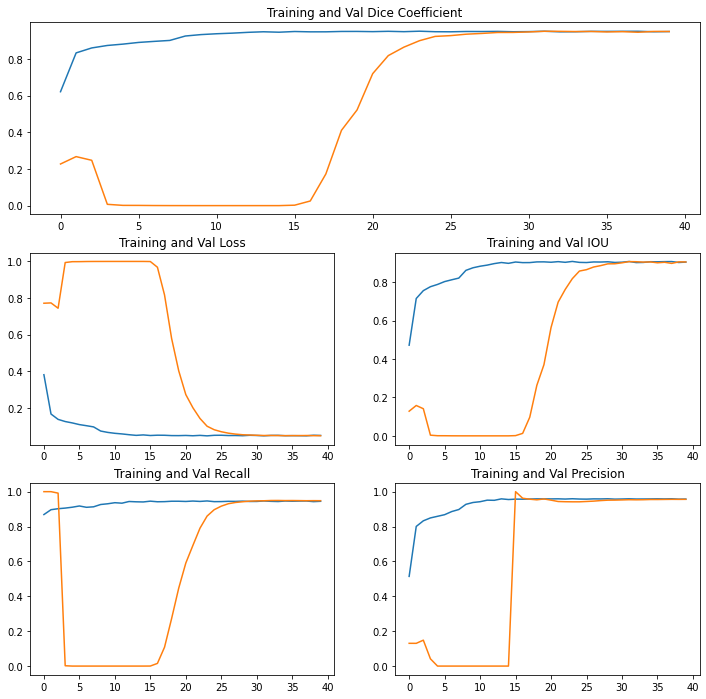

<Figure size 432x288 with 0 Axes>

In [10]:
from UNet.utilities.plot_results import plot_result
plot_result(history)

In [11]:
test_dataset = tf_dataset(test_x, test_y,  batch=batch_size)
results = model.evaluate(test_dataset, batch_size=batch_size, verbose=1)

4/4 [==============================] - 2s 295ms/step - loss: 0.0530 - dice_coef: 0.9446 - iou: 0.8951 - recall: 0.9418 - precision: 0.9549


In [12]:
print('Dice Loss for Test Data: {}'.format(results[0]))
print('Dice Coefficient for Test Data: {}'.format(results[1]))
print('IOU for Test Data: {}'.format(results[2]))
print('Precision for Test Data: {}'.format(results[4]))
print('Recall for Test Data: {}'.format(results[3]))

Dice Loss for Test Data: 0.05301016569137573
Dice Coefficient for Test Data: 0.9446262717247009
IOU for Test Data: 0.8951489925384521
Precision for Test Data: 0.9549188017845154
Recall for Test Data: 0.9418472647666931


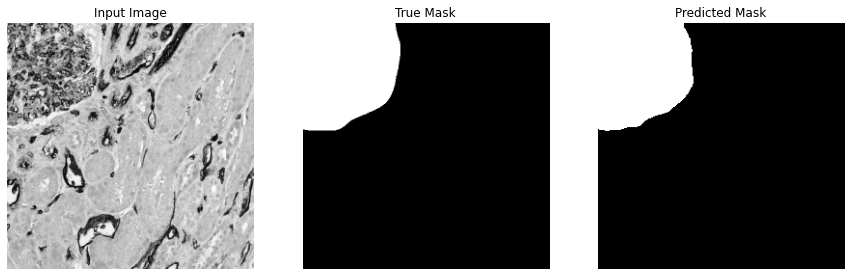

In [21]:
# Let's select a random image from test data and see what our model predicts for it.
n = np.random.randint(0, len(test_x))
img_path = test_x[n]
mask_path = test_y[n]
img = read_image(img_path)
img = np.expand_dims(img, axis=0)
y_true = read_mask(mask_path)
y_pred = model.predict(img)[0]>0.5
y_pred = y_pred.astype(np.int32)

plt.figure(figsize = (15, 15))
plt.subplot(1,3,1)
plt.imshow(img[0], cmap = 'gray')
plt.title('Input Image')
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(y_true, cmap = 'gray')
plt.title('True Mask')
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(y_pred, cmap = 'gray')
plt.title('Predicted Mask')
plt.axis('off')
plt.show()

In [19]:
print('The Dice Coefficient for given image is {}'.format(dice_coef(y_true, y_pred.astype(np.float32))))
print('The IOU for given image is {}.'.format(iou(y_true, y_pred.astype(np.float32))))

The Dice Coefficient for given image is 0.9689233303070068
The IOU for given image is 0.9397199749946594.
